In [1]:
from cat import random_literal_cat
import matplotlib.pyplot as plt
import jax
import jax.random as random
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from mean_flows import *
from dataclasses import dataclass
from tqdm import tqdm

### Check GPU Availabilility

In [2]:
# Check what devices JAX sees
devices = jax.devices()
print("JAX devices:")
for d in devices:
    print(" ", d)

# Check if GPU is available
if any(d.platform == "gpu" for d in devices):
    print("\n✅ GPU is available!")
else:
    print("\n❌ GPU is NOT available — JAX is running on CPU.")

# Run a small computation to confirm backend
x = jnp.ones((1000, 1000))
y = jnp.dot(x, x)
print(f"\nComputation result shape: {y.shape}")
print("Backend used:", jax.default_backend())

JAX devices:
  cuda:0

✅ GPU is available!

Computation result shape: (1000, 1000)
Backend used: gpu


### Target distribution

(2, 1000)


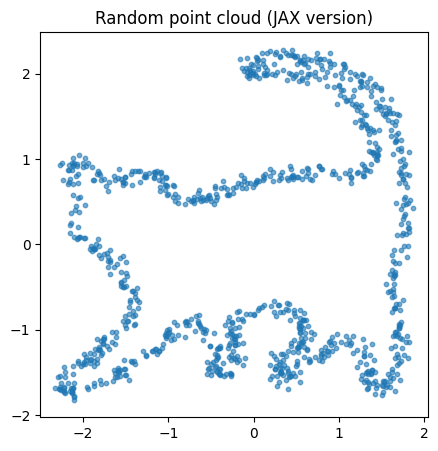

In [3]:
key = random.PRNGKey(0)
random_points = random_literal_cat(key, 1000)
print(random_points.shape)
x, y = random_points[0, :], random_points[1, :]
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10, alpha=0.6)
plt.axis("equal")
plt.title("Random point cloud (JAX version)")
plt.show()

### Model:

In [13]:

# ----- data generator (your version) -----
def make_batch(key, batch_size):
    pts = random_literal_cat(key, batch_size)  # (2, B)
    return pts.T.astype(T)                     # (B, 2)

# ----- model -----
class VelocityMLP(nn.Module):
    hidden: int = 64
    out_dim: int = 2
    @nn.compact
    def __call__(self, z, r, t):
        r = jnp.asarray(r); t = jnp.asarray(t)
        if z.ndim == 1:
            if r.ndim == 0: r = r[None]
            if t.ndim == 0: t = t[None]
            h = jnp.concatenate([z, r, t], axis=-1)
        else:
            B = z.shape[0]
            if r.ndim == 0: r = jnp.full((B,), r, dtype=z.dtype)
            if t.ndim == 0: t = jnp.full((B,), t, dtype=z.dtype)
            h = jnp.concatenate([z, r[:, None], t[:, None]], axis=-1)
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        return nn.Dense(self.out_dim)(h)

class MFTrainState(train_state.TrainState): pass

def init_meanflow(rng, hidden=128):
    model = VelocityMLP(hidden=hidden, out_dim=2)
    z0 = jnp.zeros((1,2), dtype=T)
    r0 = jnp.array(0.0, dtype=T)
    t0 = jnp.array(1.0, dtype=T)
    params = model.init(rng, z0, r0, t0)["params"]
    tx = optax.adamw(2e-3)
    state = MFTrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model




#### Train step and sampling:

In [14]:
@jax.jit
def meanflow_train_step(state, key, x):  # x: (B,2), dtype T
    def loss_fn(params):
        def fn_p(z, r, t):
            return state.apply_fn({"params": params}, z, r, t)
        return algorithm_1_jit(fn_p, x, key)   # scalar mean loss
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

def sample_minibatch(state, key, batch_size, dim=2):
    def fn_p(z, r, t):
        return state.apply_fn({"params": state.params}, z, r, t)
    return algorithm_2_jit(fn_p, dim, key, batch_size)  # (B,2)

In [15]:
def train_meanflow(num_steps, batch_size, hidden, seed):
    rng = random.PRNGKey(seed)
    rng, k_init = random.split(rng)
    state, _ = init_meanflow(k_init, hidden=hidden)

    for step in tqdm(range(1, num_steps+1)):
        rng, k_data, k_step, k_log = random.split(rng, 4)
        x = make_batch(k_data, batch_size)  # (B,2), dtype T
        state = meanflow_train_step(state, k_step, x)

        # quick loss log (optional):
        def fn_p(z, r, t): return state.apply_fn({"params": state.params}, z, r, t)
        loss = algorithm_1(fn_p, x, k_log)
        if step % 50 == 0:
            print(f"[step {step:4d}] loss={float(loss):.6f}")

    return rng, state

def demo_train_and_sample():
    rng, state = train_meanflow(num_steps=2000, batch_size=2048, hidden=128, seed=0)

    rng, k_samp, k_real = random.split(rng, 3)
    gen = sample_minibatch(state, k_samp, batch_size=2048, dim=2)  # (2048,2)
    real = make_batch(k_real, 2048)

    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,5))
        plt.scatter(real[:,0], real[:,1], s=6, alpha=0.4, label="real")
        plt.scatter(gen[:,0],  gen[:,1],  s=6, alpha=0.4, label="gen")
        plt.axis("equal"); plt.legend(); plt.title("Mean Flow training (data space)")
        plt.show()
    except Exception as e:
        print("Plot skipped:", e)
    return state

  2%|█                                          | 50/2000 [00:12<07:46,  4.18it/s]

[step   50] loss=4.319587


  5%|██                                        | 100/2000 [00:25<13:28,  2.35it/s]

[step  100] loss=4.438258


  8%|███▏                                      | 150/2000 [00:37<06:57,  4.43it/s]

[step  150] loss=4.258842


 10%|████▏                                     | 200/2000 [00:48<07:06,  4.22it/s]

[step  200] loss=4.290040


 12%|█████▎                                    | 250/2000 [01:01<06:53,  4.23it/s]

[step  250] loss=4.194148


 15%|██████▎                                   | 300/2000 [01:14<07:17,  3.88it/s]

[step  300] loss=4.216702


 18%|███████▎                                  | 350/2000 [01:26<07:21,  3.74it/s]

[step  350] loss=4.191224


 20%|████████▍                                 | 400/2000 [01:40<06:57,  3.84it/s]

[step  400] loss=4.259692


 22%|█████████▍                                | 450/2000 [01:52<06:34,  3.93it/s]

[step  450] loss=4.253968


 25%|██████████▌                               | 500/2000 [02:06<07:26,  3.36it/s]

[step  500] loss=4.318826


 28%|███████████▌                              | 550/2000 [02:18<06:26,  3.75it/s]

[step  550] loss=4.414274


 30%|████████████▌                             | 600/2000 [02:31<06:07,  3.80it/s]

[step  600] loss=4.306335


 32%|█████████████▋                            | 650/2000 [02:44<05:37,  4.00it/s]

[step  650] loss=4.247218


 35%|██████████████▋                           | 700/2000 [02:55<05:22,  4.03it/s]

[step  700] loss=4.229683


 38%|███████████████▊                          | 750/2000 [03:08<05:24,  3.85it/s]

[step  750] loss=4.209836


 40%|████████████████▊                         | 800/2000 [03:22<04:30,  4.43it/s]

[step  800] loss=4.262781


 42%|█████████████████▊                        | 850/2000 [03:34<04:51,  3.95it/s]

[step  850] loss=4.114694


 45%|██████████████████▉                       | 900/2000 [03:46<04:46,  3.83it/s]

[step  900] loss=4.258833


 48%|███████████████████▉                      | 950/2000 [03:58<04:25,  3.95it/s]

[step  950] loss=4.169995


 50%|████████████████████▌                    | 1000/2000 [04:10<03:50,  4.34it/s]

[step 1000] loss=4.243289


 52%|█████████████████████▌                   | 1050/2000 [04:24<04:05,  3.87it/s]

[step 1050] loss=4.257865


 55%|██████████████████████▌                  | 1100/2000 [04:37<03:40,  4.09it/s]

[step 1100] loss=4.160473


 57%|███████████████████████▌                 | 1150/2000 [04:49<03:39,  3.88it/s]

[step 1150] loss=4.226933


 60%|████████████████████████▌                | 1200/2000 [05:02<03:14,  4.11it/s]

[step 1200] loss=4.344846


 62%|█████████████████████████▋               | 1250/2000 [05:15<03:03,  4.09it/s]

[step 1250] loss=4.217518


 65%|██████████████████████████▋              | 1300/2000 [05:28<02:54,  4.01it/s]

[step 1300] loss=4.267603


 68%|███████████████████████████▋             | 1350/2000 [05:40<02:26,  4.43it/s]

[step 1350] loss=4.205645


 70%|████████████████████████████▋            | 1400/2000 [05:51<02:19,  4.29it/s]

[step 1400] loss=4.232784


 72%|█████████████████████████████▋           | 1450/2000 [06:04<02:07,  4.31it/s]

[step 1450] loss=4.351554


 75%|██████████████████████████████▊          | 1500/2000 [06:16<01:58,  4.21it/s]

[step 1500] loss=4.196024


 78%|███████████████████████████████▊         | 1550/2000 [06:27<01:52,  4.00it/s]

[step 1550] loss=3.996933


 80%|████████████████████████████████▊        | 1600/2000 [06:41<01:31,  4.39it/s]

[step 1600] loss=4.250629


 82%|█████████████████████████████████▊       | 1650/2000 [06:52<01:17,  4.54it/s]

[step 1650] loss=4.069687


 85%|██████████████████████████████████▊      | 1700/2000 [07:05<01:26,  3.45it/s]

[step 1700] loss=4.201121


 88%|███████████████████████████████████▉     | 1750/2000 [07:17<01:01,  4.05it/s]

[step 1750] loss=4.095983


 90%|████████████████████████████████████▉    | 1800/2000 [07:30<00:50,  4.00it/s]

[step 1800] loss=3.984095


 92%|█████████████████████████████████████▉   | 1850/2000 [07:44<00:37,  4.05it/s]

[step 1850] loss=4.291414


 95%|██████████████████████████████████████▉  | 1900/2000 [07:56<00:24,  4.06it/s]

[step 1900] loss=4.178103


 98%|███████████████████████████████████████▉ | 1950/2000 [08:08<00:12,  4.01it/s]

[step 1950] loss=4.309501


100%|█████████████████████████████████████████| 2000/2000 [08:21<00:00,  3.98it/s]

[step 2000] loss=4.112257


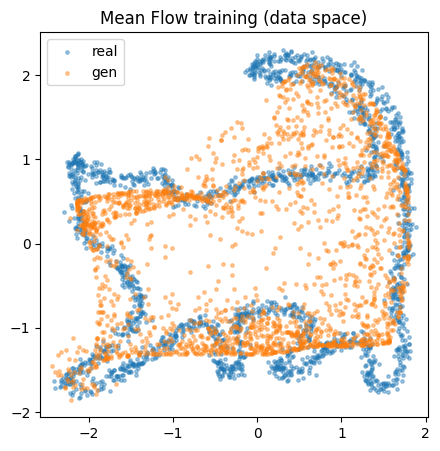

In [16]:
state = demo_train_and_sample()